In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.api import VAR
from scipy.stats import normaltest
import os
import pickle
import gc
import warnings

warnings.filterwarnings('ignore')

In [13]:
# load data
with open('../data/cluster_results/sentiment_sector_dict.pkl', 'rb') as file:
    senti_dict = pickle.load(file)
    
with open('../data/cluster_results/sentiment_summary_dict.pkl', 'rb') as file:
    senti_dict1 = pickle.load(file)

In [43]:
# related functions
def sentiment_contrast(senti_daily, proxy_data, col):
    """
    Visualizes comparison between sentiment metrics and market proxy data.
    
    Parameters:
        senti_daily (DataFrame): Daily sentiment data with datetime index
        proxy_data (DataFrame): Market proxy data with 'dt' date column
        col (str): Sentiment column name to visualize
    
    Features:
        - Automatic datetime conversion for index alignment
        - Dual-axis visualization with 20-day moving averages
        - Smart time period alignment between datasets
        - Quarterly date formatting for better temporal orientation
    """
    senti_daily = senti_daily.copy()
    if not isinstance(senti_daily.index, pd.DatetimeIndex):
        senti_daily.index = pd.to_datetime(senti_daily.index)
    if not isinstance(proxy_data['dt'], pd.DatetimeIndex):
        proxy_data['dt'] = pd.to_datetime(proxy_data['dt'])
    # Get overlapping time periods
    overlap_time = senti_daily[senti_daily.index.isin(proxy_data['dt'])].index
    # Create figure and primary axis
    fig, ax1 = plt.subplots(figsize=(16, 6))
    
    temp1 = senti_daily[senti_daily.index.isin(overlap_time)]
    temp2 = proxy_data[proxy_data['dt'].isin(overlap_time)].set_index('dt')
    
    # Plot first line (roberta_pos) on primary y-axis
    line1 = ax1.plot(temp1[col].shift().rolling(20).mean(), 
                     color='blue', label=f'{col} (20-day MA)')
    ax1.set_xlabel('Date')
    ax1.set_ylabel(f'{col}', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create secondary y-axis and plot second line
    ax2 = ax1.twinx()
    line2 = ax2.plot(temp2.rolling(20).mean(), 
                     color='red', label='Proxy Data (20-day MA)')
    ax2.set_ylabel('Proxy Value', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left')

    # Format x-axis
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)

    # Add title and grid
    plt.title(f'{col} vs Proxy Data Comparison')
    ax1.grid(True, alpha=0.3)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    plt.show()
    
    
def market_test(sentiment_cluster, sentiment_proxy, column_name_x, column_name_y):
    """
    Conducts rigorous statistical testing of market relationships.
    
    Parameters:
        sentiment_cluster (DataFrame): Independent variable dataset
        sentiment_proxy (DataFrame): Dependent variable dataset
        column_name_x (str): Independent variable column
        column_name_y (str): Dependent variable column
    
    Methodology:
        1. Data Integration: Merges datasets on datetime index
        2. Stationarity Enforcement: Automatic differencing with ADF test (max 10 diffs)
        3. Granger Causality: Tests predictive relationships at 5 lags
        4. VAR Modeling: Implements Vector Autoregression with AIC optimization
        5. Diagnostic Checks: Residual autocorrelation and normality tests
    
    Returns:
        tuple: (Granger test results, VAR model results)
    """
    data_ = pd.merge(sentiment_cluster, sentiment_proxy, left_index=True, right_on='dt')
    data = pd.DataFrame({'x': data_[column_name_x].values, 'y': data_[column_name_y].values})
       
    y_diff = data['y'].copy()
    diff_order_y = 0
    while True:
        y_adf = adfuller(y_diff)
        if y_adf[1] <= 0.05:
            break
        y_diff = y_diff.diff().dropna()
        diff_order_y += 1
        if diff_order_y > 10:  # Prevents infinite loops
            raise ValueError("After several differential scores, the ADF test is still not passed")
            
    x_diff = data['x'].copy()
    diff_order_x = 0
    while True:
        x_adf = adfuller(x_diff)
        if x_adf[1] <= 0.05:
            break
        x_diff = x_diff.diff().dropna()
        diff_order_x += 1
        if diff_order_x > 10:  # Prevents infinite loops
            raise ValueError("After several differential scores, the ADF test is still not passed")
    diff_o = diff_order_x + diff_order_y
    data = pd.DataFrame({'x': x_diff.values[diff_o:], 'y': y_diff.values[diff_o:]})
    # Perform the Granger causality test
    granger_test = grangercausalitytests(data, maxlag=5)
    
    # Fit the VAR model
    model = VAR(data)
    results = model.fit(maxlags=10, ic='aic')  # maxlags is the maximum lag order

    # View the model results
    print(results.summary())
                        
    residuals = results.resid
    for col in residuals.columns:
        print(f'Autocorrelation for {col}:')
        print(adfuller(residuals[col])[1])  # Residuals should not be autocorrelated

    # Residual normality test
    for col in residuals.columns:
        stat, p = normaltest(residuals[col])
        print(f'Normality test for {col}: p-value = {p}')
                        
    return granger_test, results

    
def crypto_test(senti_df, senti_dict, crypto_df, model_name):
    """
    Analyzes cryptocurrency returns against multiple sentiment factors.
    
    Parameters:
        senti_df (DataFrame): Base sentiment dataframe
        senti_dict (dict): Dictionary of sector-specific sentiment DataFrames
        crypto_df (DataFrame): Cryptocurrency price data
        model_name (str): Sentiment model prefix (e.g., 'finbert')
    
    Features:
        - Computes 20-day rolling sentiment averages
        - Calculates forward returns (5-day horizon)
        - Generates correlation matrices and OLS regression results
        - Supports multiple sector analysis through dictionary input
    
    Returns:
        DataFrame: Correlation matrix across all sectors
    """
    # ... exi
    crypto_df.index = crypto_df.index.astype(str)
    crypto_df['ret'] = crypto_df['Close'] / crypto_df['Close'].shift()
    crypto_df['future_ret'] = crypto_df['Close'].shift(-5) / crypto_df['Close']
    crypto_df.dropna(inplace=True)
    senti_dict['all'] = senti_df
    
    corr_li = []
    for k in senti_dict.keys():
        print(k)
        sentiment_df = senti_dict[k]
        sentiment_df = sentiment_df.shift().dropna()
        sentiment_df['pos_r'] = sentiment_df[f'{model_name}_pos'].rolling(20, min_periods=1).mean()
        sentiment_df['pos_n'] = sentiment_df[f'{model_name}_neg'].rolling(20, min_periods=1).mean()
        # Merge Bitcoin price data and sentiment data
        merged_df = pd.merge(crypto_df[['ret', 'future_ret']], sentiment_df, left_index=True, right_index=True)

        # Calculate correlations
        # correlation1 = merged_df.corr()['ret']
        correlation2 = merged_df.corr()['future_ret']
        
        X = sm.add_constant(merged_df.drop(['ret', 'future_ret'], axis=1))
        y = merged_df['future_ret']
        model = sm.OLS(y, X).fit()

        # Visualize correlations
        # print(correlation1)
        correlation2.name = k
        corr_li.append(correlation2)
        print(model.summary())
    return pd.concat(corr_li, axis=1)
    
    
def corr_test(senti_df, senti_dict, crypto_df, model_name, future_win=5, look_back=20):
    """
    Lightweight version of crypto_test for parameter sensitivity analysis.
    
    Parameters:
        future_win (int): Forward return window (days)
        look_back (int): Rolling average window (days)
    
    Differences from crypto_test:
        - Configurable time windows
        - Simplified output (correlations only)
        - No regression analysis
    """
    crypto_df.index = crypto_df.index.astype(str)
    crypto_df['ret'] = crypto_df['Close'] / crypto_df['Close'].shift()
    crypto_df['future_ret'] = crypto_df['Close'].shift(-future_win) / crypto_df['Close']
    crypto_df.dropna(inplace=True)
    senti_dict['all'] = senti_df
    
    corr_li = []
    for k in senti_dict.keys():
        sentiment_df = senti_dict[k]
        sentiment_df = sentiment_df.shift().dropna()
        sentiment_df['pos_r'] = sentiment_df[f'{model_name}_pos'].rolling(look_back).mean()
        sentiment_df['pos_n'] = sentiment_df[f'{model_name}_neg'].rolling(look_back).mean()
        # Merge Bitcoin price data and sentiment data
        merged_df = pd.merge(crypto_df[['future_ret']], sentiment_df, left_index=True, right_index=True)

        # Calculate correlations
        # correlation1 = merged_df.corr()['ret']
        correlation2 = merged_df.corr()['future_ret']

        # Visualize correlations
        # print(correlation1)
        correlation2.name = k
        corr_li.append(correlation2)
    return pd.concat(corr_li, axis=1)
    
    
def limited_ffill(series, max_fill=5):
    """
    Forward-fills NaN values with position-limited filling.
    
    Parameters:
        series (Series): Input series with missing values
        max_fill (int): Maximum consecutive fills allowed
    
    Returns:
        Series: Filled series with tracking of fill positions
    """
    mask = series.isna()
    filled = series.ffill()
    return np.where(mask.cumsum() - mask.cumsum().where(~mask).ffill().fillna(0) <= max_fill, filled, np.nan)
    

def calculate_sharpe_ratio(returns, risk_free_rate=0.02, periods_per_year=252):
    """
    Calculate annualized Sharpe ratio
    
    Parameters:
    -----------
    returns : array-like
        Daily returns (not cumulative)
    risk_free_rate : float
        Annual risk-free rate (default 2%)
    periods_per_year : int
        Trading days per year (default 252)
    """
    # Convert returns to excess returns
    excess_returns = returns - risk_free_rate/periods_per_year
    
    # Calculate annualized Sharpe Ratio
    sharpe_ratio = np.sqrt(periods_per_year) * (excess_returns.mean() / excess_returns.std())
    
    return sharpe_ratio

def sentiment_strategy(factor, crypto_df, buy_valve, max_fill=5):
    """
    Enhanced sentiment strategy with performance metrics
    """
    factor = factor[factor.index.isin(crypto_df.index)]
    crypto_df = crypto_df[crypto_df.index.isin(factor.index)].copy()
    dynamic_valve = np.where((buy_valve > factor.rolling(30).min()), buy_valve, factor.rolling(60).min()) 
    
    sig_ = np.where(((factor <= dynamic_valve) & (crypto_df['Close'] / crypto_df['Close'].shift(10) > 1)), 1, None)

    crypto_df['sig'] = sig_
    crypto_df['sig'] = crypto_df['sig'].shift().fillna(0)
    crypto_df['pos'] = limited_ffill(crypto_df['sig'], max_fill)
    
    # Calculate strategy returns
    strategy_return = np.where((crypto_df['pos'] == 1), crypto_df['ret'], 1)
    
    # Calculate daily returns for Sharpe ratio (subtract 1 to get actual returns)
    daily_returns = pd.Series(strategy_return, index=crypto_df.index) - 1
    buy_hold_returns = crypto_df['ret'] - 1
    
    # Calculate metrics
    strategy_sharpe = calculate_sharpe_ratio(daily_returns)
    buy_hold_sharpe = calculate_sharpe_ratio(buy_hold_returns)
    total_return = np.prod(strategy_return) - 1
    buy_hold_return = np.prod(crypto_df['ret']) - 1
    
    # Plotting
    if not isinstance(crypto_df.index, pd.DatetimeIndex):
        crypto_df.index = pd.to_datetime(crypto_df.index)

    plt.figure(figsize=(12, 8))
    
    # Plot cumulative returns
    plt.plot(crypto_df.index, np.cumprod(strategy_return), label='Strategy Returns')
    plt.plot(crypto_df.index, np.cumprod(crypto_df['ret']), label='Buy & Hold', color='red', alpha=0.7)

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    # Add performance metrics to plot
    metrics_text = f"""
    Strategy Metrics:
    Sharpe Ratio: {strategy_sharpe:.2f}
    Total Return: {total_return:.2%}
    
    Buy & Hold Metrics:
    Sharpe Ratio: {buy_hold_sharpe:.2f}
    Total Return: {buy_hold_return:.2%}
    """
    
    plt.title('Strategy vs Buy & Hold Performance')
    plt.xlabel('Year')
    plt.ylabel('Cumulative Return')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Add metrics text box
    plt.figtext(0.15, 0.02, metrics_text, fontsize=10, va='bottom', 
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    
    plt.tight_layout()
    plt.show()
            
    return {
        'strategy_sharpe': strategy_sharpe,
        'buy_hold_sharpe': buy_hold_sharpe,
        'strategy_return': total_return,
        'buy_hold_return': buy_hold_return,
        'daily_returns': daily_returns
    }

In [15]:
# finbert: ew, FAMC, log_FAMC
finert_famc_w = senti_dict1['finbert']['FAMC'][0]
finert_logfamc_w = senti_dict1['finbert']['log_FAMC'][0]
finert_famc_s = senti_dict['finbert']['FAMC'][0]
finert_logfamc_s = senti_dict['finbert']['log_FAMC'][0]

# deberta
deberta_famc_w = senti_dict1['deberta']['FAMC'][0]
deberta_logfamc_w = senti_dict1['deberta']['log_FAMC'][0]
deberta_famc_s = senti_dict['deberta']['FAMC'][0]
deberta_logfamc_s = senti_dict['deberta']['log_FAMC'][0]

# roberta
roberta_famc_w = senti_dict1['roberta']['FAMC'][0]
roberta_logfamc_w = senti_dict1['roberta']['log_FAMC'][0]
roberta_famc_s = senti_dict['roberta']['FAMC'][0]
roberta_logfamc_s = senti_dict['roberta']['log_FAMC'][0]


In [21]:
sentiment_proxy = pd.read_csv('../data/cluster_results/alexey-formalmethods_fear_greed_data.csv')
btc_d = pd.read_pickle('../data/cluster_results/btc_daily.pkl')
btc_d['ret'] = btc_d['Close'] / btc_d['Close'].shift()
btc_d.index = btc_d.index.astype(str)
btc_d.dropna(inplace=True)
doge_d = pd.read_pickle('../data/cluster_results/doge_daily.pkl')
doge_d['ret'] = doge_d['Close'] / doge_d['Close'].shift()
doge_d.index = doge_d.index.astype(str)
doge_d.dropna(inplace=True)
sol_d = pd.read_pickle('../data/cluster_results/sol_daily.pkl')
sol_d['ret'] = sol_d['Close'] / sol_d['Close'].shift()
sol_d.index = sol_d.index.astype(str)
sol_d.dropna(inplace=True)
eth_d = pd.read_pickle('../data/cluster_results/eth_daily.pkl')
eth_d['ret'] = eth_d['Close'] / eth_d['Close'].shift()
eth_d.index = eth_d.index.astype(str)
eth_d.dropna(inplace=True)

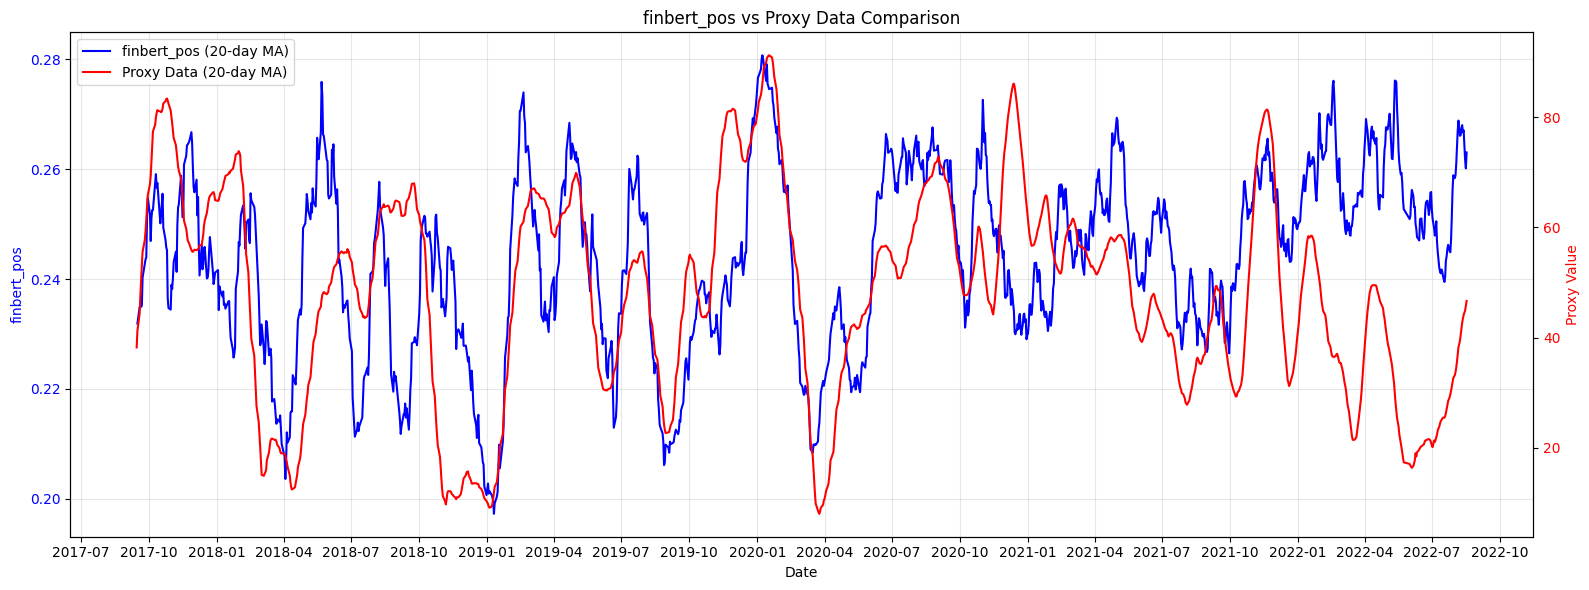

In [22]:
# finbert analysis
sentiment_contrast(finert_famc_w, sentiment_proxy, 'finbert_pos')

In [23]:
corr_test(finert_famc_w, finert_famc_s, btc_d, 'finbert', 10, 20)

,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,all
future_ret,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
finbert_pos,-0.051497,0.006455,-0.086763,0.026053,-0.025890,-0.011079,-0.010956,-0.010947,-0.001779,-0.078780,-0.013502,-0.023947
finbert_neg,0.018842,-0.001983,-0.073156,-0.070600,-0.061106,-0.050648,-0.026009,-0.041672,-0.002486,-0.078656,-0.131843,-0.050686
pos_r,-0.047010,-0.044452,-0.125401,0.018793,-0.033466,-0.025290,0.026957,-0.061967,0.012045,-0.186351,-0.136825,-0.004059
pos_n,-0.035504,0.030565,-0.209836,-0.061780,-0.049821,-0.081328,0.051263,-0.109886,-0.042749,-0.123637,-0.174639,-0.067022


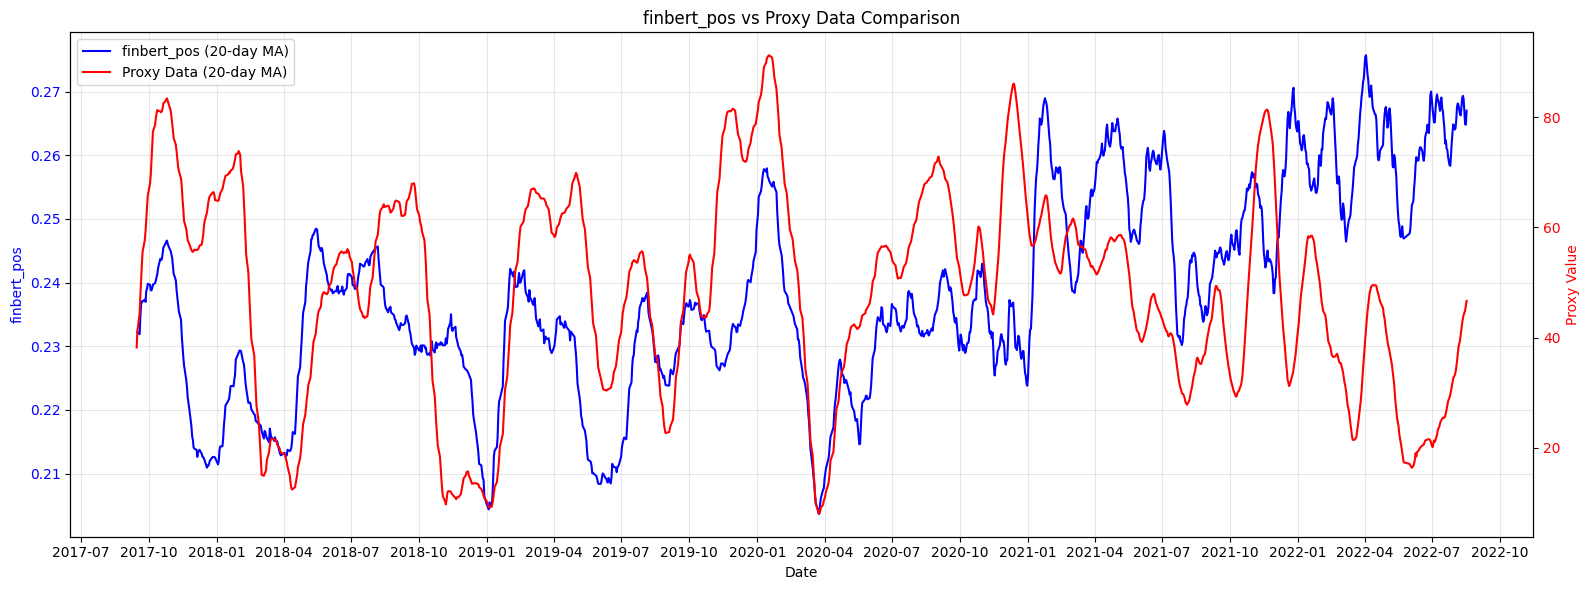

In [24]:
sentiment_contrast(finert_logfamc_w, sentiment_proxy, 'finbert_pos')

In [25]:
sentiment_proxy['20_mean_p'] = sentiment_proxy['close_value'].rolling(20).mean()
finert_logfamc_w_ = finert_logfamc_w.copy()
finert_logfamc_w_['20_mean'] = finert_logfamc_w_['finbert_pos'].rolling(20).mean()
sentiment_proxy['dt'] = sentiment_proxy['dt'].astype(str)

In [26]:
market_test(finert_logfamc_w_.dropna(), sentiment_proxy.dropna(), '20_mean', '20_mean_p')


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=17.5051 , p=0.0000  , df_denom=1430, df_num=1
ssr based chi2 test:   chi2=17.5418 , p=0.0000  , df=1
likelihood ratio test: chi2=17.4353 , p=0.0000  , df=1
parameter F test:         F=17.5051 , p=0.0000  , df_denom=1430, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.4723  , p=0.0006  , df_denom=1427, df_num=2
ssr based chi2 test:   chi2=14.9970 , p=0.0006  , df=2
likelihood ratio test: chi2=14.9190 , p=0.0006  , df=2
parameter F test:         F=7.4723  , p=0.0006  , df_denom=1427, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.7673  , p=0.0026  , df_denom=1424, df_num=3
ssr based chi2 test:   chi2=14.3721 , p=0.0024  , df=3
likelihood ratio test: chi2=14.3004 , p=0.0025  , df=3
parameter F test:         F=4.7673  , p=0.0026  , df_denom=1424, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.1075  , p=0.

({1: ({'ssr_ftest': (17.50510254620205, 3.0398329649235476e-05, 1430.0, 1),
    'ssr_chi2test': (17.541826537557718, 2.8105632404741953e-05, 1),
    'lrtest': (17.43532713856257, 2.972498514239485e-05, 1),
    'params_ftest': (17.505102546477328, 3.039832964488748e-05, 1430.0, 1.0)},
    array([[0., 1., 0.]])]),
  2: ({'ssr_ftest': (7.47231068594598, 0.0005911422340903036, 1427.0, 2),
    'ssr_chi2test': (14.996985146846031, 0.0005539187329390364, 2),
    'lrtest': (14.918999283330777, 0.0005759442779227677, 2),
    'params_ftest': (7.472310685904288, 0.0005911422341147326, 1427.0, 2.0)},
    array([[0., 0., 1., 0., 0.],
           [0., 0., 0., 1., 0.]])]),
  3: ({'ssr_ftest': (4.767258423897076, 0.002601599087196981, 1424.0, 3),
    'ssr_chi2test': (14.37207894226836, 0.0024400476169335614, 3),
    'lrtest': (14.300386430193612, 0.0025235209790053286, 3),
    'params_ftest': (4.767258423963059, 0.0026015990869576173, 1424.0, 3.0)},
    array([[0., 0., 0., 1., 0., 0., 0.],
           [

In [27]:
corr_test(finert_logfamc_w, finert_logfamc_s, btc_d, 'finbert', 20, 20)

,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,all
future_ret,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
finbert_pos,-0.166241,-0.110185,-0.153999,-0.120449,-0.059934,-0.097444,-0.158528,-0.101244,-0.067186,-0.127039,-0.141771,-0.163726
finbert_neg,0.028619,-0.078755,-0.129115,-0.032550,-0.077717,-0.107867,-0.030537,-0.129239,-0.023844,-0.161615,-0.092878,-0.094059
pos_r,-0.151726,-0.097358,-0.188036,-0.126318,-0.094673,-0.096530,-0.174583,-0.123198,-0.071958,-0.227490,-0.200492,-0.161488
pos_n,0.056700,-0.116416,-0.218043,-0.047159,-0.129830,-0.170128,-0.080633,-0.220110,-0.021464,-0.228379,-0.108641,-0.130555


In [28]:
crypto_test(finert_logfamc_w, finert_logfamc_s, btc_d, 'finbert')

10.0
                            OLS Regression Results                            
Dep. Variable:             future_ret   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     7.286
Date:                Thu, 20 Mar 2025   Prob (F-statistic):           8.08e-06
Time:                        18:42:52   Log-Likelihood:                 1781.9
No. Observations:                1842   AIC:                            -3554.
Df Residuals:                    1837   BIC:                            -3526.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.1024      0.025     44.358 

,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,all
ret,0.019620,0.019620,0.019620,0.019620,0.019620,0.019620,0.019620,0.019620,0.019620,0.019620,0.019620,0.019620
future_ret,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
finbert_pos,-0.085735,-0.085666,-0.060818,-0.057123,-0.018740,-0.052980,-0.073535,-0.032927,-0.013747,-0.039276,-0.053531,-0.074381
finbert_neg,0.008239,-0.035017,-0.075966,-0.011332,-0.049586,-0.051973,-0.020191,-0.043559,-0.002229,-0.079970,-0.082392,-0.048187
pos_r,-0.124101,-0.087693,-0.134903,-0.101485,-0.067798,-0.086190,-0.112116,-0.111802,-0.067150,-0.131830,-0.136076,-0.123631
pos_n,0.031050,-0.053200,-0.090510,-0.016042,-0.075598,-0.078010,-0.012218,-0.096200,-0.023789,-0.131348,-0.049620,-0.054147


In [29]:
corr_test(finert_logfamc_w, finert_logfamc_s, btc_d[btc_d.index < '2020-04-01'], 'finbert', 20, 20)

,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,all
future_ret,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
finbert_pos,-0.034186,-0.018662,-0.072661,-0.098041,0.013359,-0.094899,-0.114500,-0.066735,-0.040298,-0.024971,-0.050818,-0.103584
finbert_neg,-0.024466,-0.041309,-0.094395,-0.014046,-0.028353,-0.014807,0.046062,-0.089517,0.032536,-0.048823,-0.066626,-0.031999
pos_r,0.058375,0.108337,-0.015425,-0.086232,0.091606,-0.076437,-0.075629,-0.009293,-0.082706,-0.035133,-0.026294,-0.038108
pos_n,0.040464,-0.052402,-0.148873,0.058356,0.038969,0.002412,0.063781,-0.139177,0.158286,-0.002537,-0.027966,0.003244


In [30]:
crypto_test(finert_logfamc_w, finert_logfamc_s, btc_d[btc_d.index < '2020-04-01'], 'finbert')

10.0
                            OLS Regression Results                            
Dep. Variable:             future_ret   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.912
Date:                Thu, 20 Mar 2025   Prob (F-statistic):              0.106
Time:                        18:42:53   Log-Likelihood:                 826.84
No. Observations:                 948   AIC:                            -1644.
Df Residuals:                     943   BIC:                            -1619.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.0807      0.056     19.400 

,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,all
ret,0.019506,0.019506,0.019506,0.019506,0.019506,0.019506,0.019506,0.019506,0.019506,0.019506,0.019506,0.019506
future_ret,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
finbert_pos,0.015418,-0.061793,-0.035235,-0.070061,0.009448,-0.059186,-0.094432,-0.029515,0.014982,0.026728,0.003276,-0.060327
finbert_neg,-0.047092,-0.017604,-0.072587,-0.012714,-0.049019,-0.014949,-0.008284,-0.022010,-0.013445,-0.044100,-0.092521,-0.040645
pos_r,-0.048633,-0.015366,-0.074306,-0.089671,0.015631,-0.090668,-0.086106,-0.082072,-0.072033,-0.063529,-0.065455,-0.087839
pos_n,0.006545,-0.024455,-0.052894,0.016367,-0.022569,0.000067,0.051602,-0.063575,0.038815,-0.023038,-0.018555,-0.000622


In [31]:
corr_test(finert_logfamc_w, finert_logfamc_s, btc_d[btc_d.index >= '2020-04-01'], 'finbert', 20, 20)

,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,all
future_ret,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
finbert_pos,-0.324507,-0.237971,-0.256128,-0.162834,-0.166301,-0.086952,-0.231995,-0.147686,-0.100624,-0.239113,-0.251494,-0.258850
finbert_neg,0.050619,-0.161520,-0.214083,-0.114976,-0.167632,-0.240318,-0.142298,-0.208888,-0.125723,-0.324978,-0.180875,-0.213356
pos_r,-0.347572,-0.361201,-0.393568,-0.252432,-0.335608,-0.096725,-0.322566,-0.309803,-0.066021,-0.417026,-0.404075,-0.353656
pos_n,0.021598,-0.242341,-0.356986,-0.206239,-0.334600,-0.361629,-0.247142,-0.345751,-0.309508,-0.489835,-0.265211,-0.316126


In [32]:
crypto_test(finert_logfamc_w, finert_logfamc_s, btc_d[btc_d.index >= '2020-04-01'], 'finbert')

10.0
                            OLS Regression Results                            
Dep. Variable:             future_ret   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     17.40
Date:                Thu, 20 Mar 2025   Prob (F-statistic):           9.38e-14
Time:                        18:43:00   Log-Likelihood:                 990.87
No. Observations:                 887   AIC:                            -1972.
Df Residuals:                     882   BIC:                            -1948.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.2647      0.040     31.651 

,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,all
ret,0.021486,0.021486,0.021486,0.021486,0.021486,0.021486,0.021486,0.021486,0.021486,0.021486,0.021486,0.021486
future_ret,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
finbert_pos,-0.204787,-0.137039,-0.101429,-0.059347,-0.063496,-0.045610,-0.074235,-0.043441,-0.054933,-0.110443,-0.124957,-0.113002
finbert_neg,0.068815,-0.071616,-0.090456,-0.027173,-0.056368,-0.098910,-0.045334,-0.076007,0.015447,-0.131772,-0.089725,-0.070013
pos_r,-0.238087,-0.222069,-0.240321,-0.190952,-0.210347,-0.073138,-0.183302,-0.192776,-0.089349,-0.220463,-0.239240,-0.224273
pos_n,0.041103,-0.114468,-0.157915,-0.079231,-0.151045,-0.163935,-0.090182,-0.148566,-0.127403,-0.270534,-0.117277,-0.132791


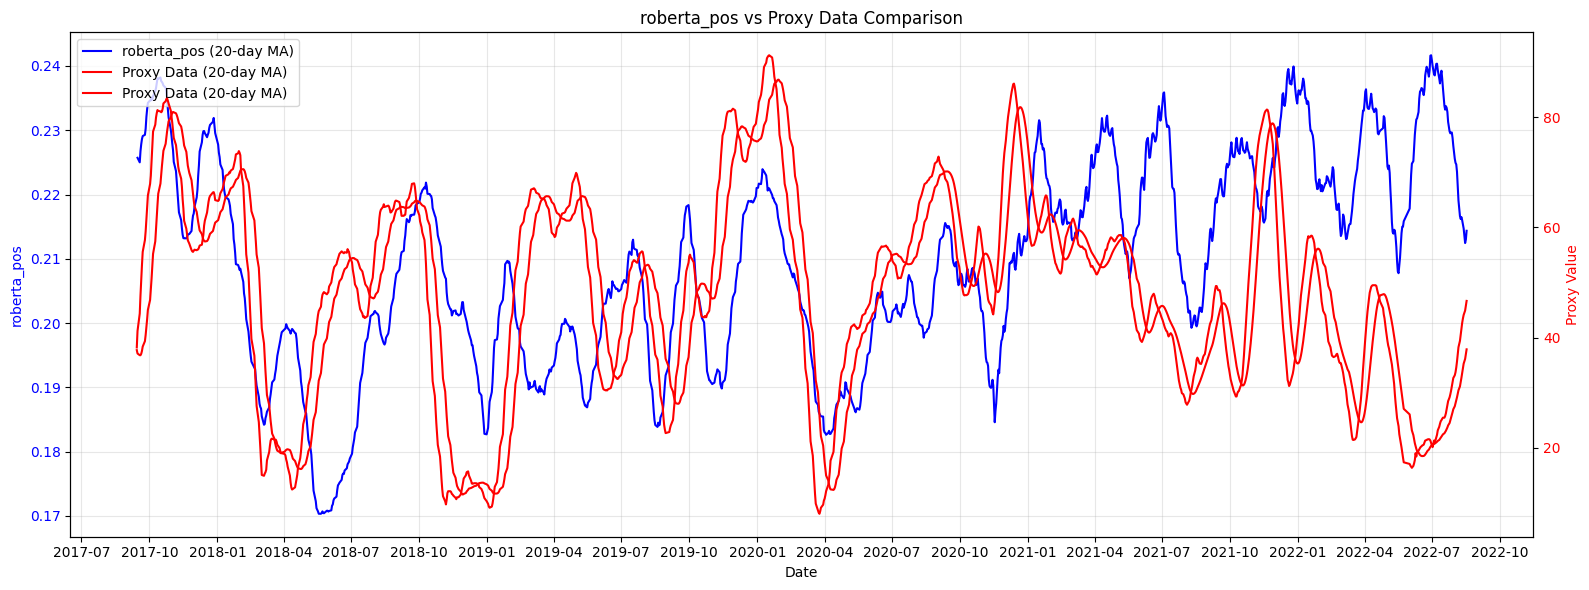

In [33]:
# roberta analysis
sentiment_contrast(roberta_logfamc_w, sentiment_proxy, 'roberta_pos')

In [34]:
corr_test(roberta_logfamc_w, roberta_logfamc_s, btc_d, 'roberta', 2, 10)

,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,all
future_ret,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
roberta_pos,-0.026044,-0.027066,0.008566,-0.011004,-0.005922,0.027386,-0.023411,0.013584,0.007313,0.021185,0.019669,-0.000332
roberta_neg,0.013952,-0.013558,-0.024549,0.004175,-0.020726,-0.004214,-0.004056,0.007575,0.062041,-0.051585,-0.040920,-0.000136
pos_r,-0.030006,-0.011899,0.011780,0.001344,0.018302,0.023472,-0.004829,0.035889,0.016342,0.015016,0.003939,0.009607
pos_n,0.041124,-0.038063,-0.017954,0.020479,0.004846,0.022083,0.027523,0.011151,0.043224,-0.037988,-0.023248,0.014981


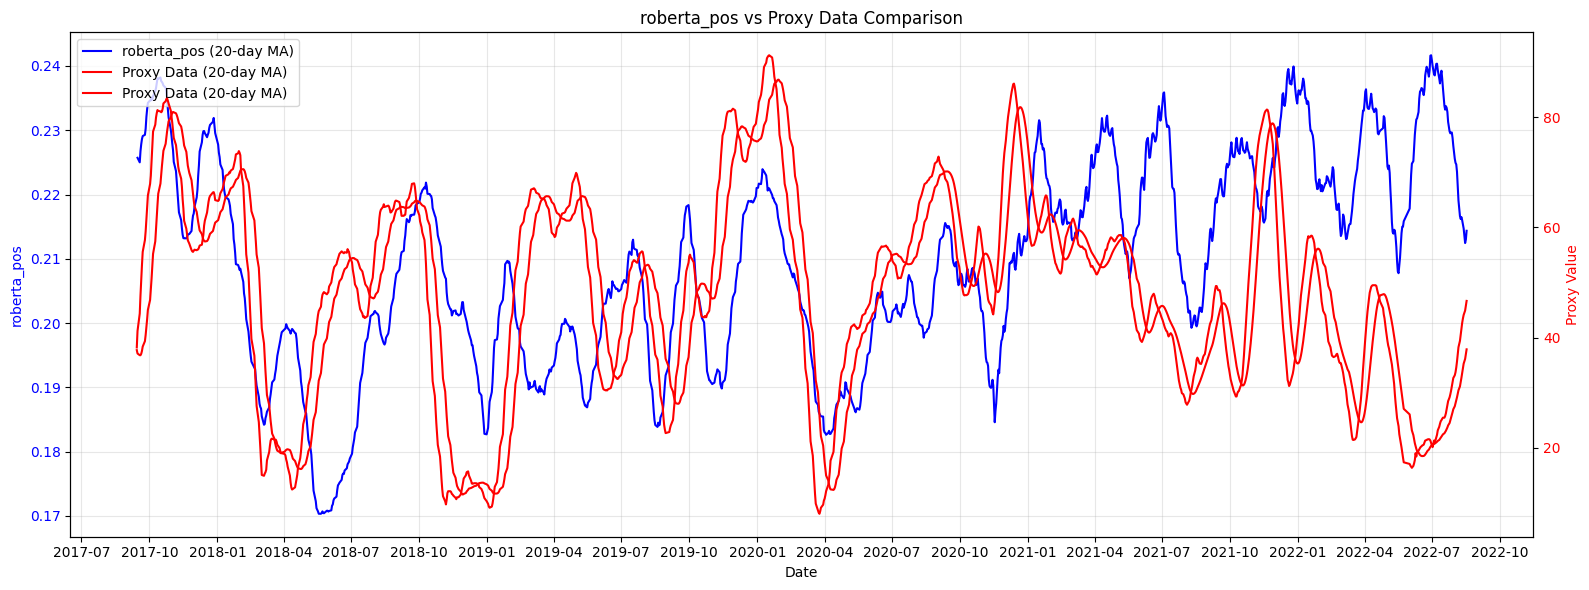

In [35]:
sentiment_contrast(roberta_logfamc_w, sentiment_proxy, 'roberta_pos')

In [36]:
corr_test(roberta_logfamc_w, roberta_logfamc_s, btc_d, 'roberta', 3, 5)

,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,all
future_ret,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
roberta_pos,-0.031344,-0.025942,0.012100,-0.004922,-0.001355,0.041468,-0.016538,0.019931,0.019122,0.016950,0.022055,0.005917
roberta_neg,0.035617,-0.021830,-0.031136,0.013864,-0.009570,0.001061,0.003732,0.020116,0.062205,-0.050074,-0.041643,0.007810
pos_r,-0.036615,-0.033128,0.009135,0.005111,0.029072,0.039195,-0.010610,0.042303,0.032744,0.019864,0.007501,0.012024
pos_n,0.044862,-0.034628,-0.031494,0.031360,0.020605,0.040707,0.029554,0.008116,0.056414,-0.047365,-0.035656,0.021221


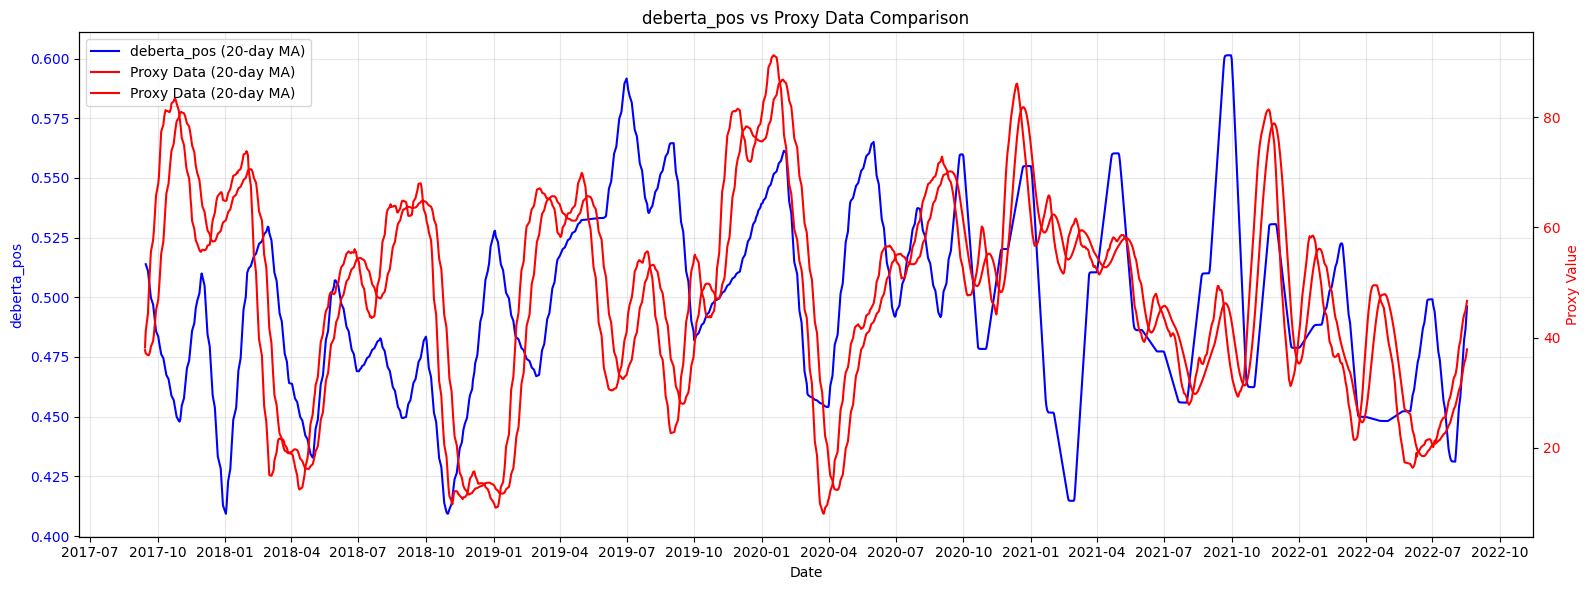

In [37]:
# deberta analysis
sentiment_contrast(deberta_logfamc_w, sentiment_proxy, 'deberta_pos')

In [38]:
corr_test(deberta_logfamc_w, deberta_logfamc_s, btc_d, 'deberta', 10, 20)

,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,all
future_ret,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
deberta_pos,0.099091,0.099310,0.098898,0.096395,0.096461,0.099761,0.098626,0.097247,0.096084,0.099111,0.098507,0.098729
deberta_neg,-0.099091,-0.099310,-0.098898,-0.096395,-0.096461,-0.099761,-0.098626,-0.097247,-0.096084,-0.099111,-0.098507,-0.098729
pos_r,0.138246,0.137764,0.137772,0.138292,0.138125,0.137075,0.137808,0.138042,0.137732,0.138507,0.136820,0.137957
pos_n,-0.138246,-0.137764,-0.137772,-0.138292,-0.138125,-0.137075,-0.137808,-0.138042,-0.137732,-0.138507,-0.136820,-0.137957


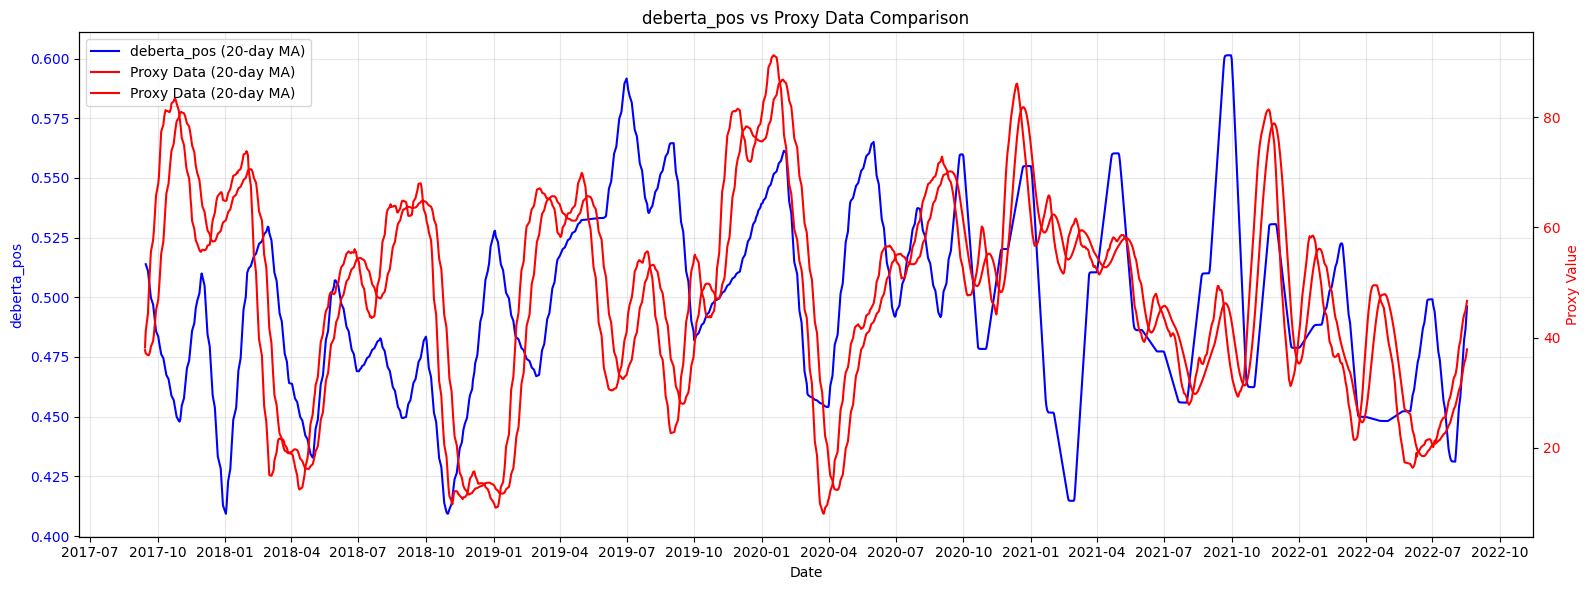

In [39]:
sentiment_contrast(deberta_logfamc_w, sentiment_proxy, 'deberta_pos')

In [40]:
corr_test(deberta_logfamc_w, deberta_logfamc_s, btc_d, 'deberta', 20, 20)

,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,all
future_ret,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
deberta_pos,0.159707,0.159656,0.159283,0.158670,0.158640,0.159325,0.159323,0.158874,0.158298,0.159860,0.158403,0.159526
deberta_neg,-0.159707,-0.159656,-0.159283,-0.158670,-0.158640,-0.159325,-0.159323,-0.158874,-0.158298,-0.159860,-0.158403,-0.159525
pos_r,0.170385,0.169581,0.170042,0.170942,0.170619,0.169165,0.169791,0.170372,0.170096,0.171505,0.168925,0.170219
pos_n,-0.170385,-0.169581,-0.170042,-0.170942,-0.170619,-0.169165,-0.169791,-0.170372,-0.170096,-0.171505,-0.168925,-0.170219


In [44]:
factor_test = finert_logfamc_s[20]['finbert_pos'].rolling(20).mean() + finert_logfamc_s[60]['finbert_pos'].rolling(20).mean() + finert_logfamc_s[55]['finbert_pos'].rolling(20).mean()

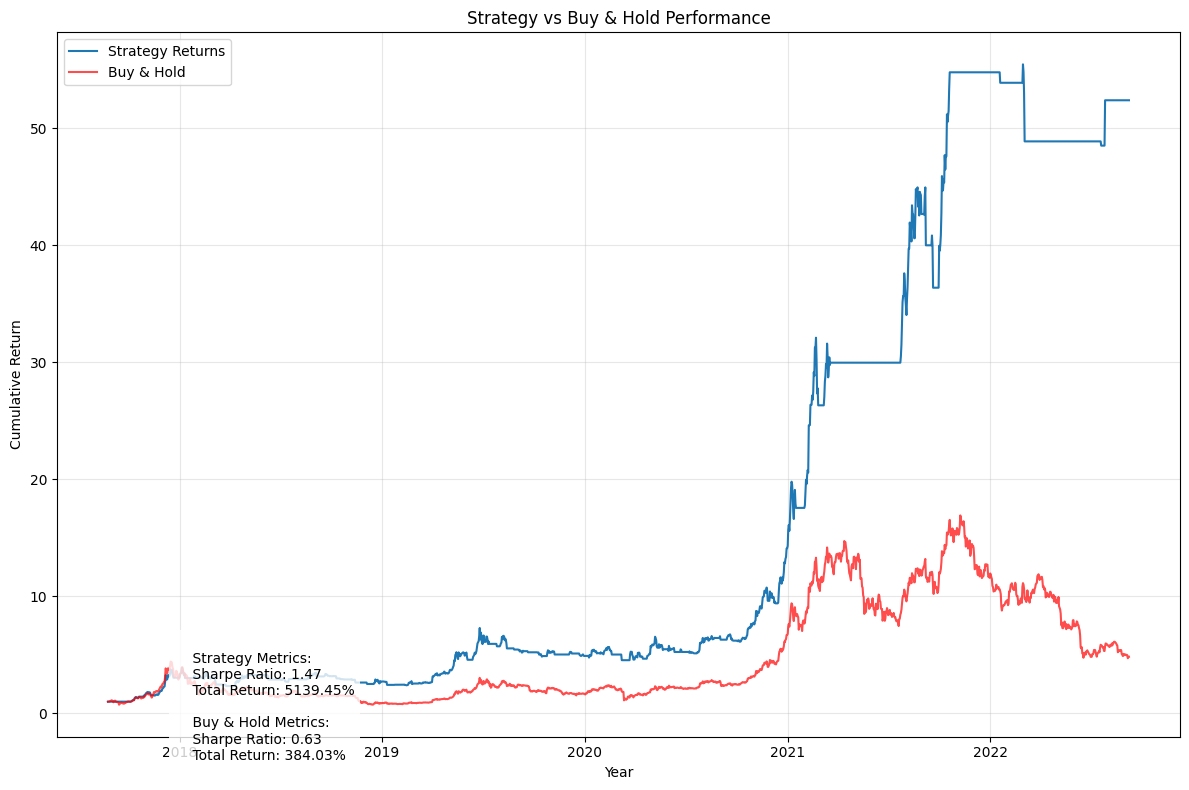


Detailed Results:
Strategy Sharpe Ratio: 1.47
Buy & Hold Sharpe Ratio: 0.63
Strategy Total Return: 5139.45%
Buy & Hold Total Return: 384.03%


In [50]:
# Run the strategy
results = sentiment_strategy(factor_test, btc_d, 0.75)

# Access the metrics
print(f"\nDetailed Results:")
print(f"Strategy Sharpe Ratio: {results['strategy_sharpe']:.2f}")
print(f"Buy & Hold Sharpe Ratio: {results['buy_hold_sharpe']:.2f}")
print(f"Strategy Total Return: {results['strategy_return']:.2%}")
print(f"Buy & Hold Total Return: {results['buy_hold_return']:.2%}")

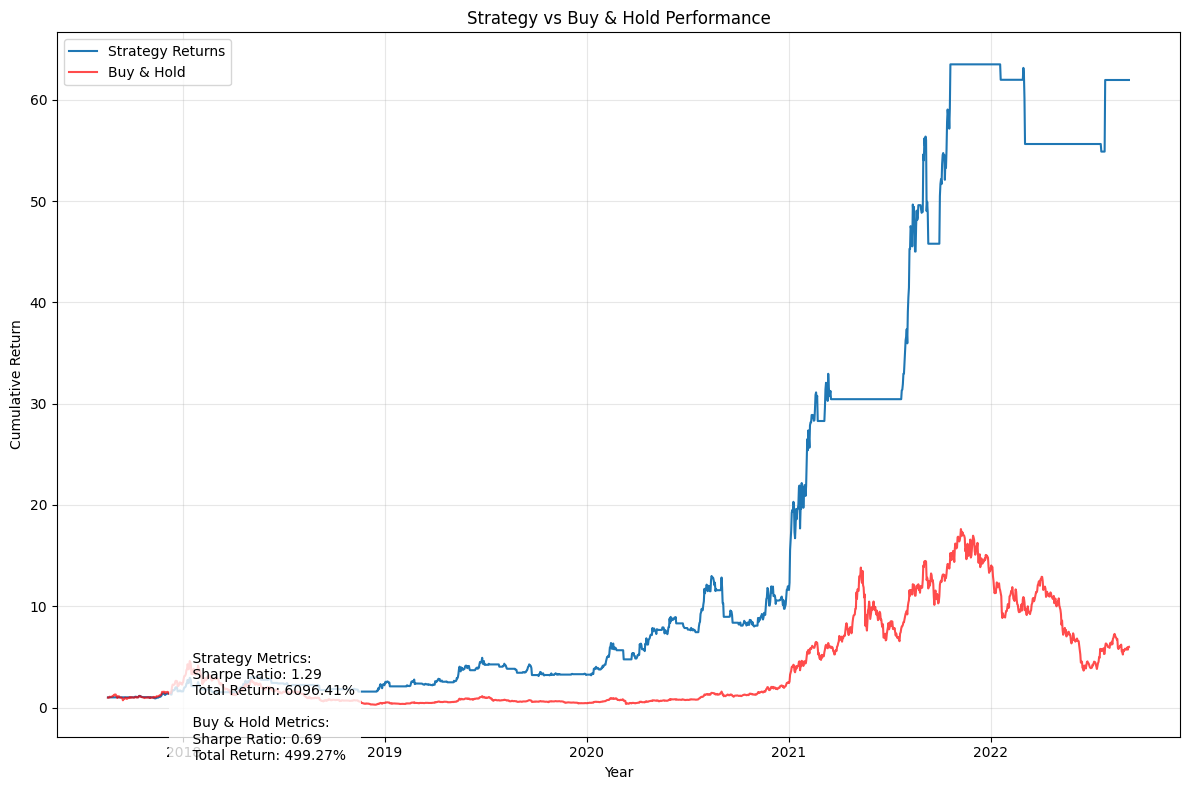


Detailed Results:
Strategy Sharpe Ratio: 1.29
Buy & Hold Sharpe Ratio: 0.69
Strategy Total Return: 6096.41%
Buy & Hold Total Return: 499.27%


In [52]:
# Run the strategy
results = sentiment_strategy(factor_test, eth_d, 0.75)

# Access the metrics
print(f"\nDetailed Results:")
print(f"Strategy Sharpe Ratio: {results['strategy_sharpe']:.2f}")
print(f"Buy & Hold Sharpe Ratio: {results['buy_hold_sharpe']:.2f}")
print(f"Strategy Total Return: {results['strategy_return']:.2%}")
print(f"Buy & Hold Total Return: {results['buy_hold_return']:.2%}")

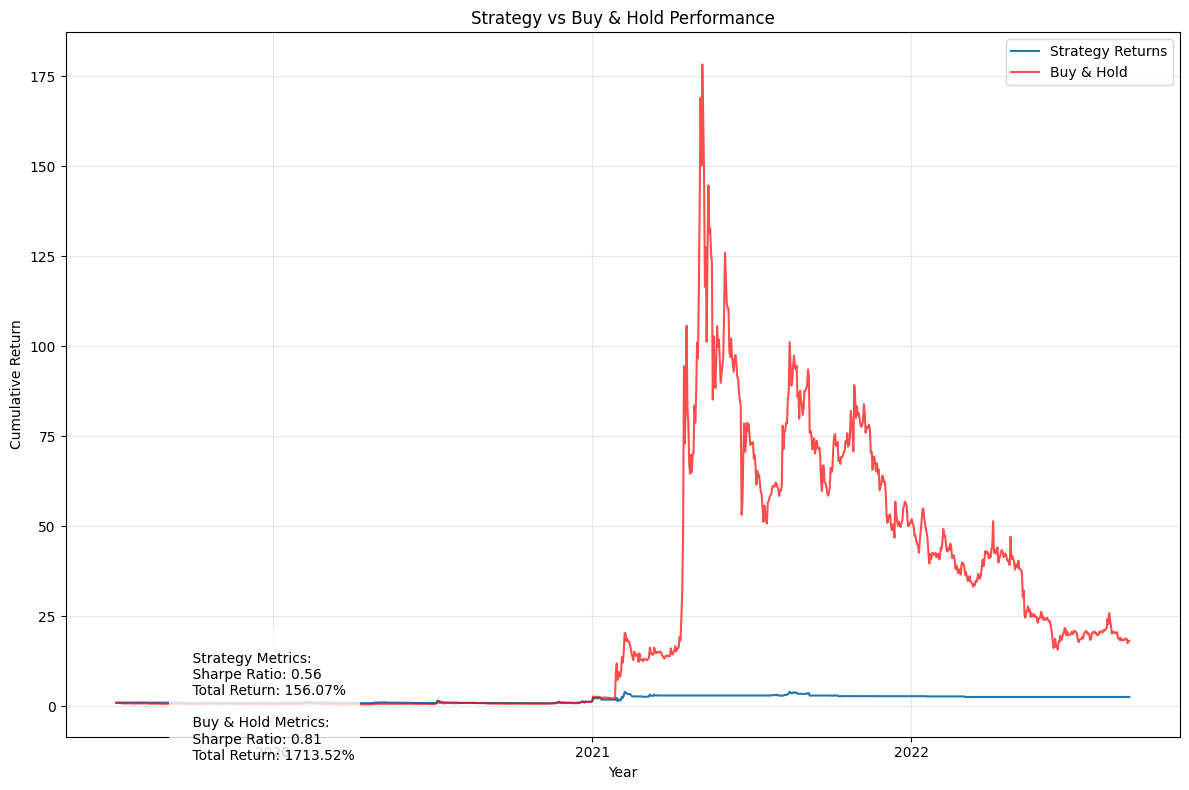


Detailed Results:
Strategy Sharpe Ratio: 1.47
Buy & Hold Sharpe Ratio: 0.63
Strategy Total Return: 5139.45%
Buy & Hold Total Return: 384.03%


In [ ]:
result = sentiment_strategy(factor_test, doge_d, 0.75)

print(f"\nDetailed Results:")
print(f"Strategy Sharpe Ratio: {results['strategy_sharpe']:.2f}")
print(f"Buy & Hold Sharpe Ratio: {results['buy_hold_sharpe']:.2f}")
print(f"Strategy Total Return: {results['strategy_return']:.2%}")
print(f"Buy & Hold Total Return: {results['buy_hold_return']:.2%}")

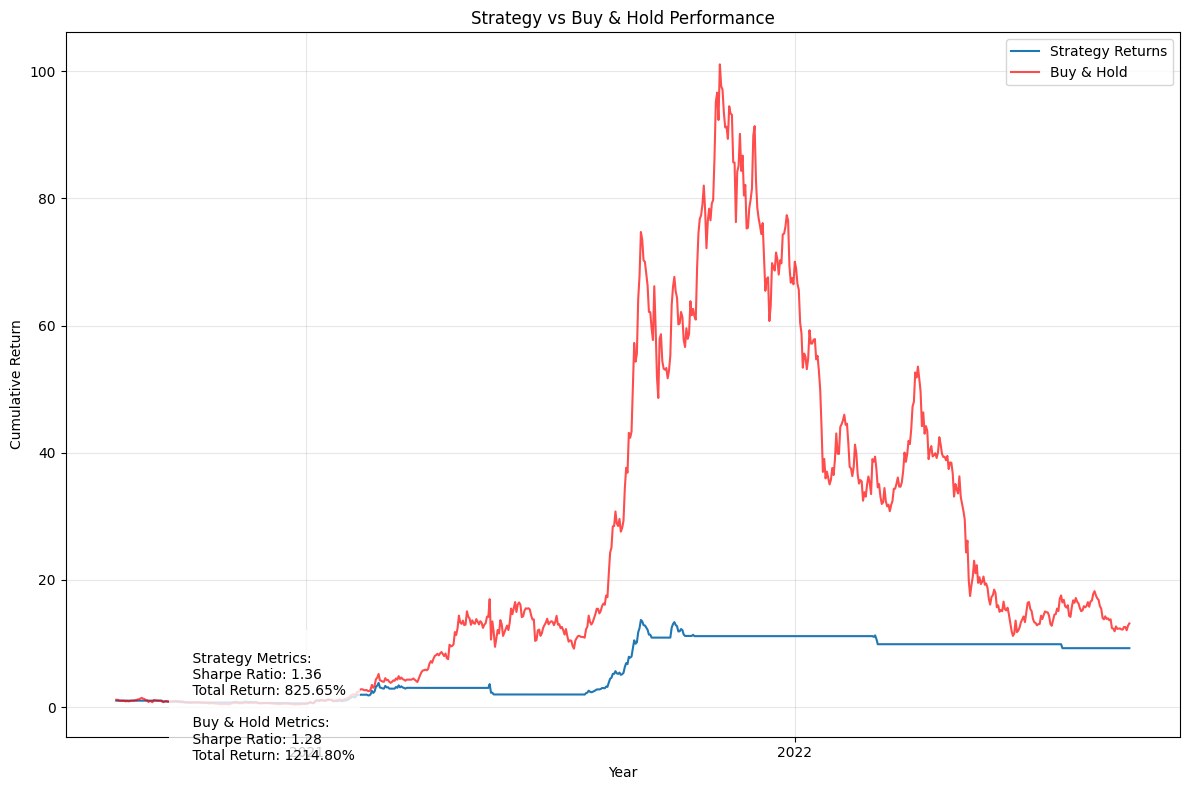


Detailed Results:
Strategy Sharpe Ratio: 1.36
Buy & Hold Sharpe Ratio: 1.28
Strategy Total Return: 825.65%
Buy & Hold Total Return: 1214.80%


In [48]:
results = sentiment_strategy(factor_test, sol_d, 0.75)

# Access the metrics
print(f"\nDetailed Results:")
print(f"Strategy Sharpe Ratio: {results['strategy_sharpe']:.2f}")
print(f"Buy & Hold Sharpe Ratio: {results['buy_hold_sharpe']:.2f}")
print(f"Strategy Total Return: {results['strategy_return']:.2%}")
print(f"Buy & Hold Total Return: {results['buy_hold_return']:.2%}")